## Sentiment Analysis of Amazon reviews for JBL Speaker

In this notebook, the reviews from Amazon on JBL Speaker were analyzed. 

In [48]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import sqlite3
import warnings
warnings.filterwarnings("ignore")

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix
%matplotlib inline

#### Data Preparation and Visualization:

In [49]:
#reading the sqlite file and making a df from the data
con = sqlite3.connect("Amazon.sqlite")
df = pd.read_sql_query("SELECT * from JLB", con)

In [50]:
#Showing the head of the dataset
df.head()

,rating,date,location,color,review_title,review,comment
0,1.0,January-29-2019,United States,Gray,Buy a Charge 3,The JBL Charge 4 has one giant flaw that frank...,11
1,3.0,December-12-2018,United States,Black,JBL could make the Charger4 better BUT nop the...,Too bad JBL lower the sound quality on the cha...,3
2,5.0,October-26-2018,United States,Black,Sounds great and has plenty of colume,I've been using a JBL Flip 2 for the past coup...,1
3,5.0,June-3-2019,United States,Gray,In depth review for jbl charge 4,The JBL charge 4 is a great product. I found i...,2
4,4.0,December-5-2018,United States,Red,Awesome Sound! We'll see how long it lasts!,Great build quality.Great sound!Does not autom...,1


In [51]:
df.shape

(1652, 7)

Checking to see if there is any null data in our dataset:

In [52]:
df_nulls = df[df.isnull().apply(lambda x: max(x), axis=1)]
df_nulls.head()

,rating,date,location,color,review_title,review,comment
1651,5.0,June-4-2019,United States,None,None,None,None


In [53]:
df.reset_index()
df.dropna()
df.drop_duplicates()
df = df.mask(df.eq('None')).dropna()

In [54]:
df_nulls = df[df.isnull().apply(lambda x: max(x), axis=1)]
df_nulls.head()

,rating,date,location,color,review_title,review,comment


Changing the rating values to a binary form. To do this, first we check the relationship between rating and comments:

In [55]:
#converting the data to numerical
df['rating'] = pd.to_numeric(df['rating'], errors='coerce')
df = df.replace(np.nan, 0, regex=True)
df['comment'] = pd.to_numeric(df['comment'], errors='coerce')
df = df.replace(np.nan, 0, regex=True)

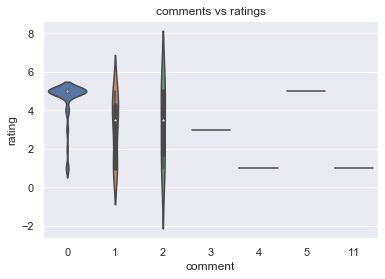

In [56]:
sns.violinplot(df['comment'], df['rating'])
plt.title("comments vs ratings")
plt.show()

##### Plotting the average rating vesus the color of the speaker

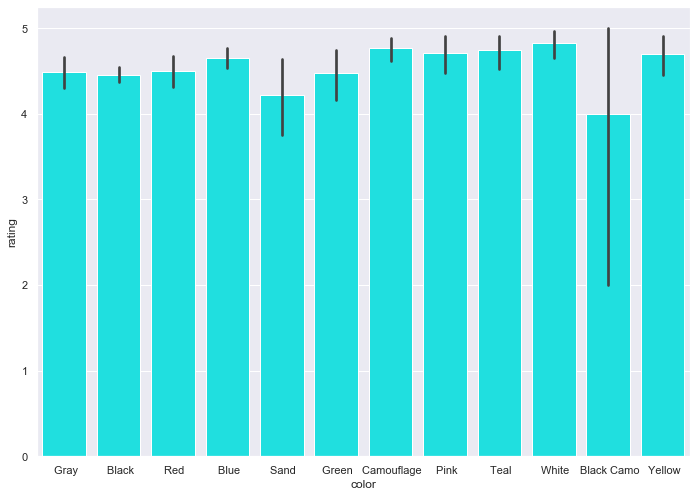

In [57]:
#plotting average rating versus color of the speaker
ax=sns.set(rc={'figure.figsize':(11.7,8.27)})
ax=sns.barplot(x='color', y='rating', data=df, color='cyan')

##### Plotting the distribution of difrenet color in JBL speakers reviewed in dataset

In [58]:
import plotly.graph_objs as go
import plotly.offline as py

In [59]:
ratings = df['color'].value_counts()
#colors = ['cyan', 'mediumturquoise']

label_rating = ratings.index
size_rating = ratings.values

rating_piechart = go.Pie(labels = label_rating,
                         values = size_rating,
                         name = 'JBL Speaker', hole = 0.0)

pdf = [rating_piechart]

layout = go.Layout(title = 'Distribution of Color for JBL Speaker in dataset')

fig = go.Figure(data = pdf, layout = layout)
fig.update_traces(hoverinfo='label+percent+value', textinfo='value', textfont_size=20,
                  marker=dict(line=dict(color='#000000', width=0.2)))

py.iplot(fig)

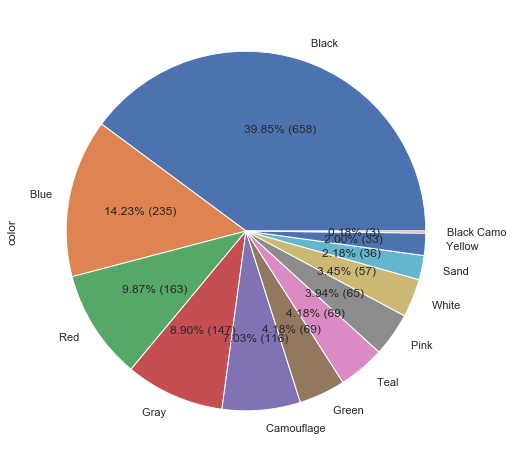

In [60]:
#Plotting the distribution of colors of speaker in the dataset using matplotlip
total = df['color'].value_counts().sum()
df['color'].value_counts().plot(kind='pie', autopct=lambda p:'{:.2f}% ({:.0f})'.format(p,p * total / 100))
                              

In [61]:
df['rating'] = np.where(df['rating'] >= 3, 1, 0)

In [62]:
df.sample(10)

,rating,date,location,color,review_title,review,comment
662,1,August-19-2019,United States,Camouflage,Great value,My nephew loves it !,0
790,1,March-22-2020,United States,Pink,Awesome,Just love it 😆 I 🎸 all the time,0
980,1,October-8-2019,United States,Camouflage,Great sound short battery life,Great product but bring a charger the battery ...,0
1494,1,January-17-2020,United States,Gray,Awesome,Awesome sound,0
664,1,July-22-2019,United States,Black,Love it!!,This is one of the best bluetooth speakers I h...,0
552,1,July-25-2019,United States,Blue,Awesome speaker,Very happy. Easy to use.,0
1237,1,July-21-2019,United States,Camouflage,"Excellent sound, great value",Great bass sound,0
1077,1,June-23-2019,United States,Blue,Satisfied...I bought two.,"This is my second charge 4. One sounds good, s...",0
459,1,February-18-2019,United States,Black,Boom in my Backpack!,I can fit it in a draw-string backpack on the ...,0
1323,1,January-7-2020,United States,White,Can sink it with my other jbl for surround sound,Sounds great use it everyday around the house.,0


Performing some statistical analysis on the data

In [63]:
df.describe(include='all')

,rating,date,location,color,review_title,review,comment
count,1651.000000,1651,1651,1651,1651,1651,1651.000000
unique,NaN,447,1,12,1310,1541,NaN
top,NaN,January-2-2020,United States,Black,Great speaker,Love it,NaN
freq,NaN,20,1651,658,27,12,NaN
mean,0.918231,NaN,NaN,NaN,NaN,NaN,0.039976
std,0.274095,NaN,NaN,NaN,NaN,NaN,0.464080
min,0.000000,NaN,NaN,NaN,NaN,NaN,0.000000
25%,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000
50%,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000
75%,1.000000,NaN,NaN,NaN,NaN,NaN,0.000000


In [64]:
df.groupby('rating').describe()

comment                                              
         count      mean       std  min  25%  50%  75%   max
rating                                                      
0        135.0  0.259259  1.398096  0.0  0.0  0.0  0.0  11.0
1       1516.0  0.020449  0.238762  0.0  0.0  0.0  0.0   5.0

According to the table above most of the users are satisfied with the JLB Speaker.

Here we will add a new column to our dataframe and will check the length of the reviews:

In [65]:
#Adding a new column and entering the length of the reviews:
df['length_of_review'] = df['review'].apply(len)
df.head()

,rating,date,location,color,review_title,review,comment,length_of_review
0,0,January-29-2019,United States,Gray,Buy a Charge 3,The JBL Charge 4 has one giant flaw that frank...,11,345
1,1,December-12-2018,United States,Black,JBL could make the Charger4 better BUT nop the...,Too bad JBL lower the sound quality on the cha...,3,238
2,1,October-26-2018,United States,Black,Sounds great and has plenty of colume,I've been using a JBL Flip 2 for the past coup...,1,531
3,1,June-3-2019,United States,Gray,In depth review for jbl charge 4,The JBL charge 4 is a great product. I found i...,2,2636
4,1,December-5-2018,United States,Red,Awesome Sound! We'll see how long it lasts!,Great build quality.Great sound!Does not autom...,1,614


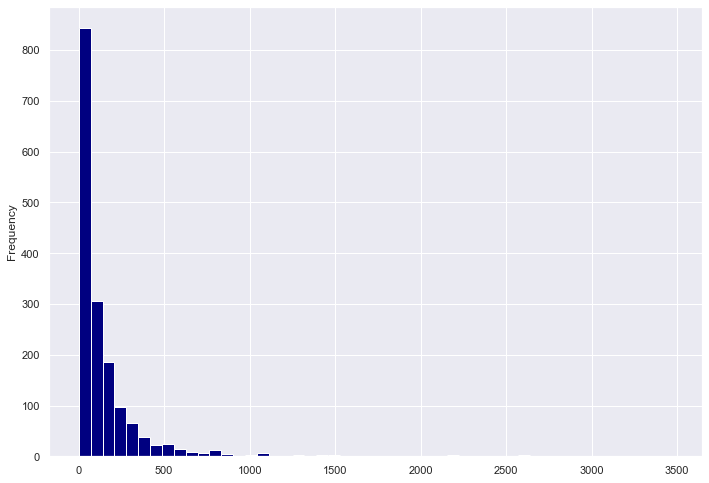

In [67]:
#Plotting the histogram of the length of reviews
df['length_of_review'].plot(bins=50, kind='hist', color='navy');

The Distribution Plot above, illustrates a distribution of Length of the Reviews written by buyers for BD Coffee Maker. Most of the Reviews are between 0 to 500 words.

In [68]:
#Describing the data according to the length of reviews
df.groupby('length_of_review').describe().sample(10)

rating                                              comment  \
                  count      mean       std  min  25%  50%  75%  max   count   
length_of_review                                                               
171                 3.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0     3.0   
169                 1.0  1.000000       NaN  1.0  1.0  1.0  1.0  1.0     1.0   
44                 14.0  0.928571  0.267261  0.0  1.0  1.0  1.0  1.0    14.0   
17                 18.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0    18.0   
503                 1.0  0.000000       NaN  0.0  0.0  0.0  0.0  0.0     1.0   
200                 5.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0     5.0   
64                  6.0  1.000000  0.000000  1.0  1.0  1.0  1.0  1.0     6.0   
495                 1.0  1.000000       NaN  1.0  1.0  1.0  1.0  1.0     1.0   
223                 1.0  1.000000       NaN  1.0  1.0  1.0  1.0  1.0     1.0   
511                 1.0  1.000000       NaN  1.0  1.0  1.0  1.0  1.0     1.0   

                                                     
                 mean  std  min  25%  50%  75%  max  
length_of_review                                     
171               0.0  0.0  0.0  0.0  0.0  0.0  0.0  
169               0.0  NaN  0.0  0.0  0.0  0.0  0.0  
44                0.0  0.0  0.0  0.0  0.0  0.0  0.0  
17                0.0  0.0  0.0  0.0  0.0  0.0  0.0  
503               0.0  NaN  0.0  0.0  0.0  0.0  0.0  
200               0.0  0.0  0.0  0.0  0.0  0.0  0.0  
64                0.0  0.0  0.0  0.0  0.0  0.0  0.0  
495               0.0  NaN  0.0  0.0  0.0  0.0  0.0  
223               0.0  NaN  0.0  0.0  0.0  0.0  0.0  
511               0.0  NaN  0.0  0.0  0.0  0.0  0.0

Here we will plot the histograms of the length of reviews for high ratings and low ratings to see if there is a difference:

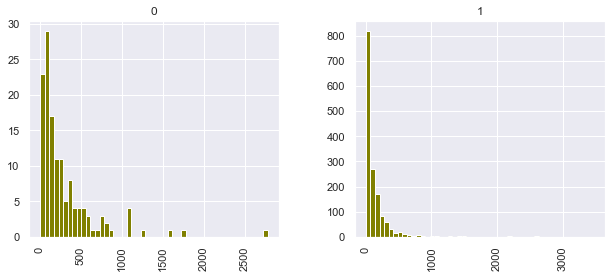

In [69]:
df.hist(column='length_of_review', by='rating', bins=50,figsize=(10,4), color='olive');

Unsatisfied people have written longer sentences when reviewing the product.

Here in a Pie Chart the percentage of satisfied versus unsatisfid people with the Coffee Maker will be depicted.

In [70]:
import plotly.graph_objs as go
import plotly.offline as py

In [71]:
ratings = df['rating'].value_counts()
colors = ['gold', 'mediumturquoise']

label_rating = ratings.index
size_rating = ratings.values

rating_piechart = go.Pie(labels = label_rating,
                         values = size_rating,
                         name = 'JBL Speaker', hole = 0.0)

pdf = [rating_piechart]

layout = go.Layout(title = 'Distribution of Ratings for JBL Speaker')

fig = go.Figure(data = pdf, layout = layout)
fig.update_traces(hoverinfo='label+percent+value', textinfo='value', textfont_size=20,
                  marker=dict(colors=colors, line=dict(color='#000000', width=2)))

py.iplot(fig)

##### Plotting length of review versus rating

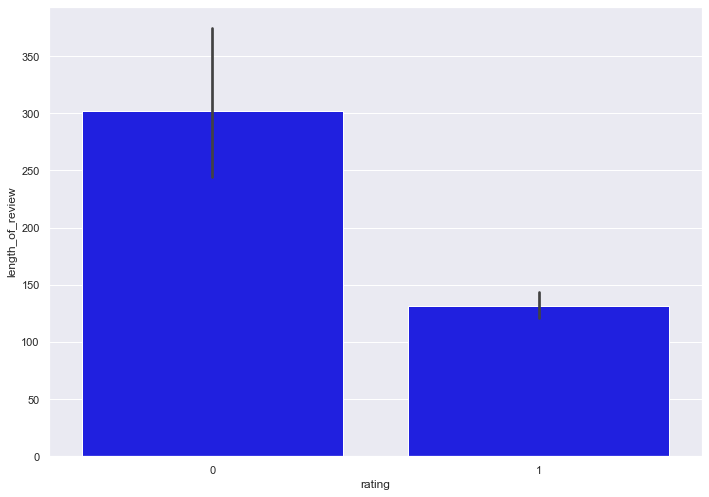

In [82]:
#plotting average length of review versus rating
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x='rating', y='length_of_review', data=df, color='blue')

##### Plotting length of review versus number of comments

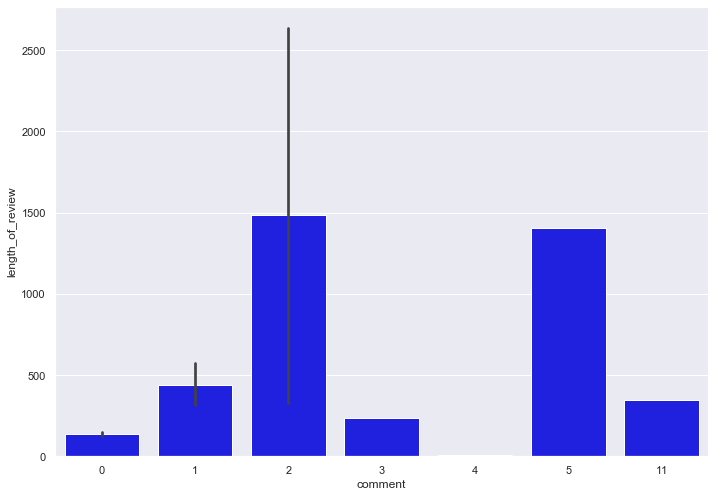

In [83]:
#plotting average length of review versus rating
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x='comment', y='length_of_review', data=df, color='blue')

##### Plotting rating versus number of comments

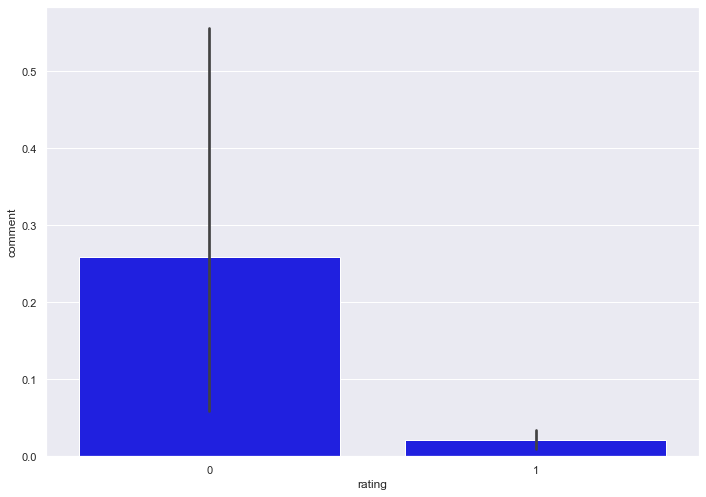

In [84]:
#plotting average number of comments versus rating
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x='rating', y='comment', data=df, color='blue')

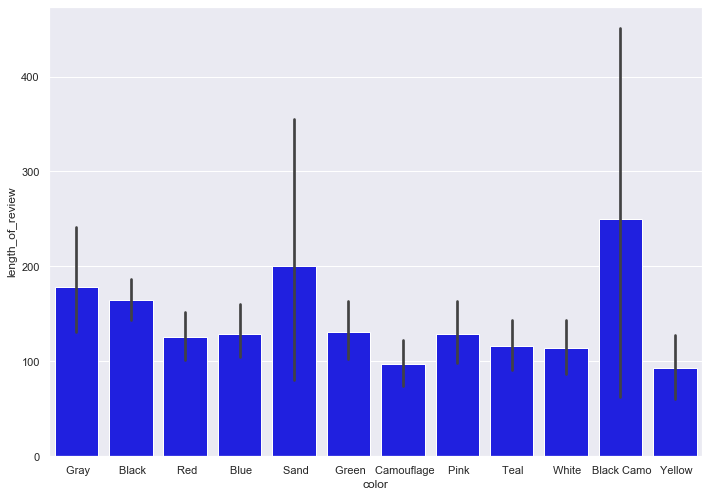

In [85]:
#plotting average number of comments versus rating
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x='color', y='length_of_review', data=df, color='blue')

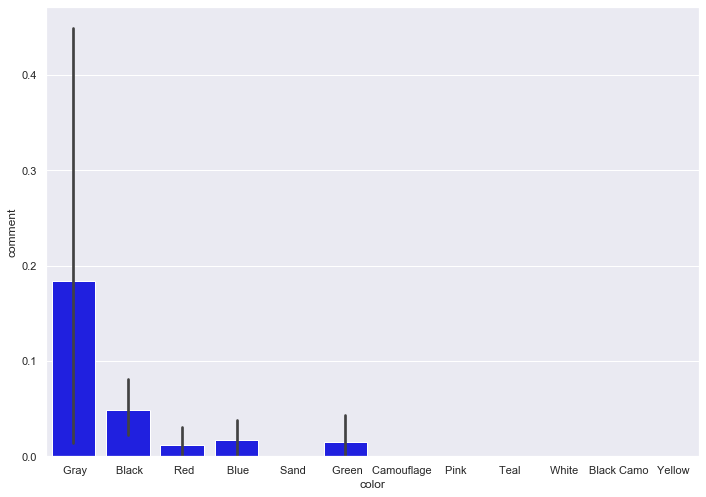

In [86]:
#plotting average number of comments versus rating
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.barplot(x='color', y='comment', data=df, color='blue')

Adding another column to the dataframe named feedback and specifying in it which review has received a comment (1) and which has not(0).

In [87]:
df['feedback'] = np.where(df['comment'] > 0, 1, 0)

In [88]:
df.sample(10)

,rating,date,location,color,review_title,review,comment,length_of_review,feedback
902,1,September-9-2019,United States,Black,Big sound from such a small can!,I bought this for the home shop and it makes a...,0,81,0
526,1,April-2-2019,United States,Black,Very recommend,High quality. Fast shipping,0,27,0
1160,1,January-17-2020,United States,Black,Great quality,Great quality,0,13,0
697,1,January-7-2020,United States,Green,Great so far...,Xmas gift. Great so far,0,23,0
1390,1,February-13-2020,United States,Black,Travel a lot,Easy to travel with,0,19,0
1082,0,May-8-2019,United States,Black,I could have bought from a store for a few dol...,"My new jbl charge 4 came, open used missing pa...",0,96,0
383,1,July-20-2019,United States,Green,It’s a must buy,I like the color I chose and the quality of so...,0,136,0
1052,1,July-3-2019,United States,White,Perfect portable speaker,"Great sound, would purchase another with out a...",0,62,0
1447,1,June-30-2019,United States,Red,Muy bueno,Excelente,0,9,0
984,1,December-10-2019,United States,Black,Great speaker,Awesome product!!,0,17,0


In [89]:
df.describe()

,rating,comment,length_of_review,feedback
count,1651.000000,1651.000000,1651.000000,1651.000000
mean,0.918231,0.039976,144.966081,0.016354
std,0.274095,0.464080,248.560484,0.126870
min,0.000000,0.000000,1.000000,0.000000
25%,1.000000,0.000000,25.500000,0.000000
50%,1.000000,0.000000,67.000000,0.000000
75%,1.000000,0.000000,168.000000,0.000000
max,1.000000,11.000000,3473.000000,1.000000


Here the most frequenctly repeated words in reviews will be retreived.

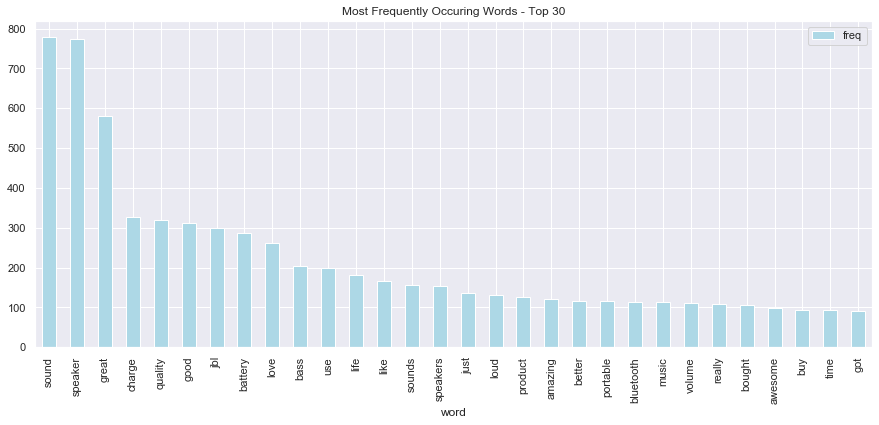

In [90]:
from sklearn.feature_extraction.text import CountVectorizer


cv = CountVectorizer(stop_words = 'english')
words = cv.fit_transform(df.review) #learn a vocabulary
sum_words = words.sum(axis=0)


words_freq = [(word, sum_words[0, idx]) for word, idx in cv.vocabulary_.items()]
words_freq = sorted(words_freq, key = lambda x: x[1], reverse = True)
frequency = pd.DataFrame(words_freq, columns=['word', 'freq'])

frequency.head(30).plot(x='word', y='freq', kind='bar', color='lightblue', figsize=(15, 6))
plt.title("Most Frequently Occuring Words - Top 30")
plt.show()

The bar graph above indicates the most frequently used words in the reviews. This will give us some idea about people's thoughts on the JBL Speaker.

In [91]:
import spacy
import string
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

!python -m spacy download en_core_web_md

stopwords = stopwords.words('english')
punctuations = string.punctuation
nlp = spacy.load('en_core_web_sm')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kaveh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


In [92]:
import spacy
import string
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

!python -m spacy download en_core_web_md


stopwords = stopwords.words('english')
punctuations = string.punctuation
nlp = spacy.load('en_core_web_sm')
def cleanup_text(docs, logging=False):
    texts = []
    counter = 1
    table = str.maketrans({key: None for key in string.punctuation})

    for doc in docs:
        if counter % 1000 == 0 and logging:
            print("Processed %d out of %d documents." % (counter, len(docs)))
        counter += 1
        doc = nlp(doc, disable=['parser', 'ner'])
        ###Convert text to lowercase, strip whitespace and remove personal pronouns
        tokens = [tok.lemma_.lower().strip() for tok in doc if tok.lemma_ != '-PRON-']
        ###Remove stopwords
        tokens = [tok.translate(table) for tok in tokens if tok not in stopwords ]
        tokens = ' '.join(tokens)
        #Remove extra whitespace
        tokens = ' '.join(tokens.split())
        texts.append(tokens)
    return pd.Series(texts)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Kaveh\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


[+] Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


Defining two variables (X, y) which are our train and test variables. X that is a train variable, would be a text from 'review_title' and test variable (y) would be the 'feedback'.

In [93]:
X = cleanup_text(df["review_title"],logging=True)
y = df.iloc[:,8].values

Processed 1000 out of 1651 documents.


#### Bag of Words 
The following script uses the bag of words model to convert text documents into corresponding numerical features:


In [94]:
from sklearn.feature_extraction.text import CountVectorizer
vectorizer = CountVectorizer(max_features=1500, min_df=5, max_df=0.7)
X_train = vectorizer.fit_transform(X).toarray()

In [95]:
from sklearn.feature_extraction.text import TfidfTransformer
tfidfconverter = TfidfTransformer()
X_train = tfidfconverter.fit_transform(X_train).toarray()

The above script convert values into TFIDF values.

This script divides data into 20% test set and 80% training set.

In [96]:
#training and testing
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X_train, y, test_size = 0.3, random_state = 100)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(1155, 123)
(1155,)
(496, 123)
(496,)


In [97]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix

classifier = RandomForestClassifier()
classifier.fit(x_train, y_train)

y_pred = classifier.predict(x_test)

print("Training Accuracy :", classifier.score(x_train, y_train))
print("Testing Accuracy :", classifier.score(x_test, y_test))

cm = confusion_matrix(y_test, y_pred)
print(cm)

Training Accuracy : 0.9904761904761905
Testing Accuracy : 0.9717741935483871
[[480   6]
 [  8   2]]


In [98]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print( '------------------------------', 'Confusion Matrix:', '\n', confusion_matrix(y_test,y_pred))
print('\n', '------------------------------', 'F1 measure:', '\n', '\n', classification_report(y_test,y_pred))
print('\n',  '------------------------------', 'Accuracy Score:', '\n', accuracy_score(y_test, y_pred))

------------------------------ Confusion Matrix: 
 [[480   6]
 [  8   2]]

 ------------------------------ F1 measure: 
 
              precision    recall  f1-score   support

          0       0.98      0.99      0.99       486
          1       0.25      0.20      0.22        10

avg / total       0.97      0.97      0.97       496


 ------------------------------ Accuracy Score: 
 0.9717741935483871
